In [10]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW, get_scheduler, GPT2Config
from torch.nn.functional import softmax
import datasets
from datasets import load_dataset, Dataset
import random
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from torchmetrics import F1Score
pd.options.mode.copy_on_write = True
from accelerate import init_empty_weights, infer_auto_device_map
from accelerate.utils import load_checkpoint_in_model
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print(os.environ.get("PYTORCH_CUDA_ALLOC_CONF"))

expandable_segments:True


In [11]:
fpath2 = "./datasets_ready/Task_Achievement.csv"
df2 = pd.read_csv(fpath2)
df2['score'] = df2['score'].round(1)
df_filtered2 = df2[(df2['score'] > 1.5) & (df2['score'] < 12.0)]

reverse_mapping_3 = {
    3.5: 0, 4.0: 0,
    4.5: 1, 5.0: 1,
    5.5: 2, 6.0: 2,
    6.5: 3, 7.0: 3,
    7.5: 4, 8.0: 4,
    8.5: 5, 9.0: 5
}

df_filtered2['score'] = df_filtered2['score'].map(reverse_mapping_3)

df_sampled2 = df_filtered2.groupby('score').sample(
    n=290, 
    random_state=42
).reset_index(drop=True)

df_sampled2['score'] = df_sampled2['score'].astype(int)

dataset2 = Dataset.from_pandas(df_sampled2)

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

c:\Users\26597\miniconda3\envs\ece1786\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\26597\.cache\huggingface\hub\models--openai-community--gpt2-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\26597\miniconda3\envs\ece1786\lib\site-packages\torch\nn\modules\module.py:1160: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

c:\Users\26597\miniconda3\envs\ece1786\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/522 [00:00<?, ?it/s]c:\Users\26597\miniconda3\envs\ece1786\lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:545: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
 33%|███▎      | 174/522 [3:26:54<7:10:16, 74.18s/it]

Epoch 1/3: train loss 1.8396, val loss 1.7863, val accuracy 0.2085


 67%|██████▋   | 348/522 [7:54:40<3:39:38, 75.74s/it]   

Epoch 2/3: train loss 1.8050, val loss 1.7706, val accuracy 0.2232


100%|██████████| 522/522 [12:26:11<00:00, 76.39s/it]    

Epoch 3/3: train loss 1.8063, val loss 1.7665, val accuracy 0.2389


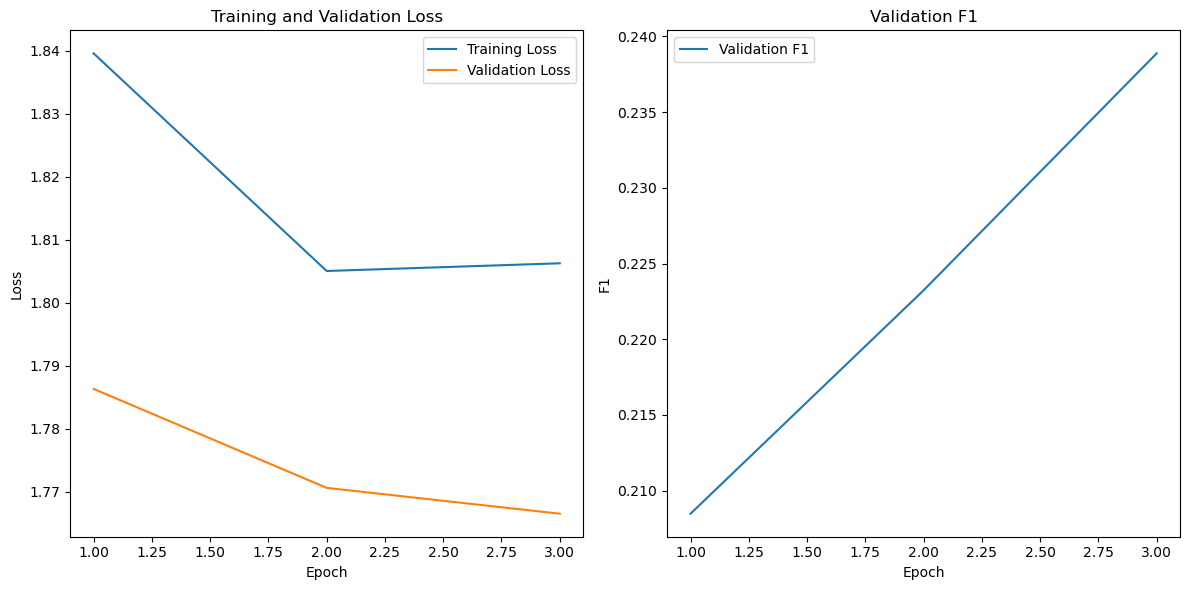

Final validation F1: 0.2389


In [ ]:
num_labels_2 = 6

# Move model2 to device (GPU if available)
device2 = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Set up configuration and add pad token ID

configuration2 = GPT2Config.from_pretrained("openai-community/gpt2-large")
configuration2.pad_token_id = configuration2.eos_token_id  # Use eos_token_id as the pad token
configuration2.num_labels = num_labels_2  # Update the number of labels

# Load tokenizer and set pad token
tokenizer2 = GPT2Tokenizer.from_pretrained("openai-community/gpt2-large")
tokenizer2.pad_token = tokenizer2.eos_token  # Set pad token to eos token

# Load model with configuration
model2 = GPT2ForSequenceClassification.from_pretrained(
    "openai-community/gpt2-large", 
    config=configuration2, 
    ignore_mismatched_sizes=True
).to(device2)

# Freeze GPT-2 transformer layers
for param in model2.transformer.parameters():
    param.requires_grad = False

# Tokenization function
def tokenize_function(examples):
    # Concatenate the input columns for each example in the batch
    combined_text = [
        p + " " + e + " " + t for p, e, t in zip(examples["prompt"], examples["essay"], examples["text"])
    ]
    # Tokenize the concatenated text
    return tokenizer2(combined_text, padding="max_length", truncation=True, max_length=1024)

# Tokenize the dataset
tokenized_datasets2 = dataset2.map(tokenize_function, batched=True)
tokenized_datasets2 = tokenized_datasets2.remove_columns(["prompt", "essay", "text"])
tokenized_datasets2 = tokenized_datasets2.rename_column("score", "labels")
tokenized_datasets2.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Get the labels from the tokenized dataset
labels2 = tokenized_datasets2["labels"]

# Get the unique labels
unique_labels2 = np.unique(labels2)

# Store the indices for each label
label_to_indices2 = {label: np.where(labels2 == label)[0] for label in unique_labels2}

# Lists to hold the train and validation indices
train_indices2 = []
val_indices2 = []

# For each label, split the indices into train and validation
for label, indices in label_to_indices2.items():
    # Shuffle the indices within each label to ensure random splitting
    np.random.shuffle(indices)
    
    # Split 80% for training, 20% for validation
    split_idx2 = int(0.8 * len(indices))
    train_indices2.extend(indices[:split_idx2])
    val_indices2.extend(indices[split_idx2:])

# Convert indices to tensors
train_indices2 = torch.tensor(train_indices2)
val_indices2 = torch.tensor(val_indices2)

# Create Subsets for train and validation datasets
train_dataset2 = Subset(tokenized_datasets2, train_indices2)
eval_dataset2 = Subset(tokenized_datasets2, val_indices2)

# Dataloaders
train_dataloader2 = DataLoader(train_dataset2, shuffle=True, batch_size=8)
eval_dataloader2 = DataLoader(eval_dataset2, batch_size=8)

# Set up optimizer and scheduler
# optimizer2 = AdamW(model2.parameters(), lr=1e-5)

# Ensure only the classification head is trainable
optimizer2 = AdamW(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-5)

num_epochs2 = 3
num_training_steps2 = num_epochs2 * len(train_dataloader2)
lr_scheduler2 = get_scheduler(
    name="linear", optimizer=optimizer2, num_warmup_steps=0, num_training_steps=num_training_steps2
)

# Initialize lists to track training/validation losses and accuracies
train_losses2 = []
val_losses2 = []
val_f1_scores2 = []

# Training loop
progress_bar2 = tqdm(range(num_training_steps2))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric2 = F1Score(task="multiclass", num_classes=num_labels_2, average="weighted").to(device2)

for epoch in range(num_epochs2):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric2.reset()
    model2.train()

    for batch in train_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        outputs = model2(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer2.step()
        lr_scheduler2.step()
        optimizer2.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar2.update(1)

    # Record training loss for the epoch
    train_losses2.append(epoch_train_loss / len(train_dataloader2))

    # Evaluate the model2
    model2.eval()
    for batch in eval_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model2(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric2(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses2.append(epoch_val_loss / len(eval_dataloader2))
    val_f12 = f1_metric2.compute().item()
    val_f1_scores2.append(val_f12)

    print(f"Epoch {epoch + 1}/{num_epochs2}: train loss {train_losses2[-1]:.4f}, val loss {val_losses2[-1]:.4f}, val accuracy {val_f1_scores2[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses2, val_losses2, val_f1_scores2)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores2[-1]:.4f}")

In [ ]:
torch.save(model2.state_dict(), "./saved_models/gpt2_large_3epoch_weights_new.pt")

# Save optimizer and scheduler if needed
torch.save({
    'optimizer_state_dict': optimizer2.state_dict(),
    'scheduler_state_dict': lr_scheduler2.state_dict()
}, "./saved_models/training_state.pt")

torch.save(model2.classifier.state_dict(), "./saved_model/classifier_head.pt")

AttributeError: 'GPT2ForSequenceClassification' object has no attribute 'classifier'

In [31]:
for batch in train_dataloader2:
    batch = {k: v.to(device2) for k, v in batch.items()}
    print(batch)
    # with torch.no_grad():
    #     outputs = model2(**batch)

    #     logits = outputs.logits
    #     predictions = torch.argmax(logits, dim=-1)
    #     # loss = F.cross_entropy(logits, batch["labels"])

    #     # epoch_val_loss += loss.item()
    #     # f1_metric2(predictions, batch["labels"])  # Update F1 metric with predictions
    #     print(predictions)
    # break

{'labels': tensor([0, 1, 2, 2, 0, 0, 2, 5], device='cuda:0'), 'input_ids': tensor([[ 4366,   661,   892,  ..., 50256, 50256, 50256],
        [  464,  3707,   286,  ..., 50256, 50256, 50256],
        [ 4366, 11390,  1975,  ..., 50256, 50256, 50256],
        ...,
        [  464,  1266,   835,  ..., 50256, 50256, 50256],
        [ 4366,   661,   892,  ..., 50256, 50256, 50256],
        [ 4366,   661,   892,  ..., 50256, 50256, 50256]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}
{'labels': tensor([0, 5, 1, 1, 1, 2, 4, 1], device='cuda:0'), 'input_ids': tensor([[  464,  1266,   835,  ..., 50256, 50256, 50256],
        [  818,   617,  2678,  ..., 50256, 50256, 50256],
        [11246,   661,  1975,  ..., 50256, 50256, 50256],
        ...,
        [11246,  2678,   517,

In [19]:
from pprint import pprint
model2
pprint(dir(model2))

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_assisted_decoding',
 '_auto_class',
 '_autoset_attn_implementation',
 '_backward_compatibility_gradient_checkpointing',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_beam_search',
 '_buffers',
 '_call_impl',
 '_check_and_enable_flash_attn_2',
 '_check_and_enable_sdpa',
 '_compiled_call_impl',
 '_constrained_beam_search',
 '_contrastive_search',
 '_convert_head_mask_to_5d',
 '_copy_lm_head_original_to_resized',
 '_create_repo',
 '_dispatch_accelerate_model',
 '_dola_decoding',
 '_expand_inputs_for_generation',

In [16]:
for name, param in model2.classifier.named_parameters():
    print(f"Parameter Name: {name}")
    print(f"Shape: {param.shape}")
    print(f"Requires Grad: {param.requires_grad}")
    print()

AttributeError: 'GPT2ForSequenceClassification' object has no attribute 'classifier'